# Data Cleansing and Preparation:
## The following data cleansing and preparation steps were followed by the work in the source below:
### https://www.kaggle.com/code/unstructuredrahul/deep-learning-pytorch-binary-classification
## The neural-network model implementation, analysis, and evaluation are unique to this notebook with.

------------------------------------------------------------------------
This notebook is a Multi Layer Perceptron(MLP) implementation for a Tabular data classification problem using Pytorch . Are **Neural Nets an overkill or do they lack performance on Tabular data** ? 

Well recently there has been a lot of buzz around utility of NN's in tabular data.In a study , Gradient boosting methods still outperform most scenarios of tabular data world . Related reading in this paper - [Deep Learning is not all you need](https://arxiv.org/pdf/2106.03253.pdf)

Please remember to **upvote this notebook** for encouragement , i'll be grateful :-)

--------------------------------------------------------------------------

### Background on the Dataset 📝
**What is Phishing ?**

It is a form of fraud in which the attacker tries to learn sensitive information such as login credentials or account information by pretending as a reputable entity or person via email or other communication channel means

Phishing is popular among attackers, since it is easier to trick someone into clicking a malicious link which seems legitimate

The **URL** of phishing websites may be **very similar to real websites** to the human eye, but they are different in IP. 

#### URL Basics

![URL Structure](https://i.imgur.com/elrD4Vl.png)

* **Domain name** portion is constrained since it has to be registered with a domain name Registrar
* **Subdomain name** and **Path** are fully controllable by the phisher

### Phishing dataset Exploration

In [1]:
!pip install torch

  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.3-py3-none-any.whl.metadata (12 kB)
  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/199.3 MB ? eta -:--:--
    --------------------------------------- 4.7/199.3 MB 28.4 MB/s eta 0:00:07
   -- ------------------------------------- 14.2/199.3 MB 40.4 MB/s eta 0:00:05
   ---- ----------------------------------- 22.3/199.3 MB 39.1 MB/s eta 0:00:05
   ------ --------------------------------- 31.5/199.3 MB 39.9 MB/s eta 0:00:05
   -------- ------------------------------- 40.9/199.3 MB 41.3 MB/s eta 0:00:04
   ---------- ----------------------------- 51.9/199.3 MB 42.9 MB/s eta 0:00:04
   ------------ --------------------------- 61.1/199.3 MB 43.2 MB/s eta 0:00:04
   -------------- ------------------------- 71.0/199.3 MB 44.0 MB/s eta 0:00:03
   ---------------- --------------

In [2]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix
from sklearn.metrics import *

#-- Pytorch specific libraries import -----#
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df_data = pd.read_csv("../../../data/dataset_phishing.csv")
df_data.shape

(11430, 89)

In [4]:
df_data.head(5)

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


#### Quick Observations
* **URL** itself is present as a field
* Target Variable is : **status** with 
    * legitimate (considered as Label 1)
    * phishing   (considered as Label 0)
* **87 Features** around URL , **all Numerical** ,are from three different classes
    * 56 extracted from the Structure and Syntax of URLs (fields starting with : *nb_* , *shortest/longest* , *ratio/length* etc)
    * 24 extracted from the Content of their correspondent pages 
    * 7 are extracted by querying External Services

In [5]:
#Encoding 'status' as label 1 & 0 , naming the field as target
df_data['target'] = pd.get_dummies(df_data['status'])['legitimate'].astype('int')
df_data.drop('status',axis = 1, inplace=True)
df_data[['url','target']].head(5)

,url,target
0,http://www.crestonwood.com/router.php,1
1,http://shadetreetechnology.com/V4/validation/a...,0
2,https://support-appleld.com.secureupdate.duila...,0
3,http://rgipt.ac.in,1
4,http://www.iracing.com/tracks/gateway-motorspo...,1


**No Missing values in the dataset**

In [6]:
tmp = df_data.isnull().sum().reset_index(name='missing_val')
tmp[tmp['missing_val']!= 0]

,index,missing_val


**Idenitfying Categorical columns** : If column has unique values lower than 0.002% of total records then categorizing it as Categorical

In [7]:
likely_cat = {}
for var in df_data.iloc[:,1:].columns:
    likely_cat[var] = 1.*df_data[var].nunique()/df_data[var].count() < 0.002 

num_cols = []
cat_cols = []
for col in likely_cat.keys():
    if (likely_cat[col] == False):
        num_cols.append(col)
    else:
        cat_cols.append(col)


#### Distribution of Mean values of the Numerical features across Target variable

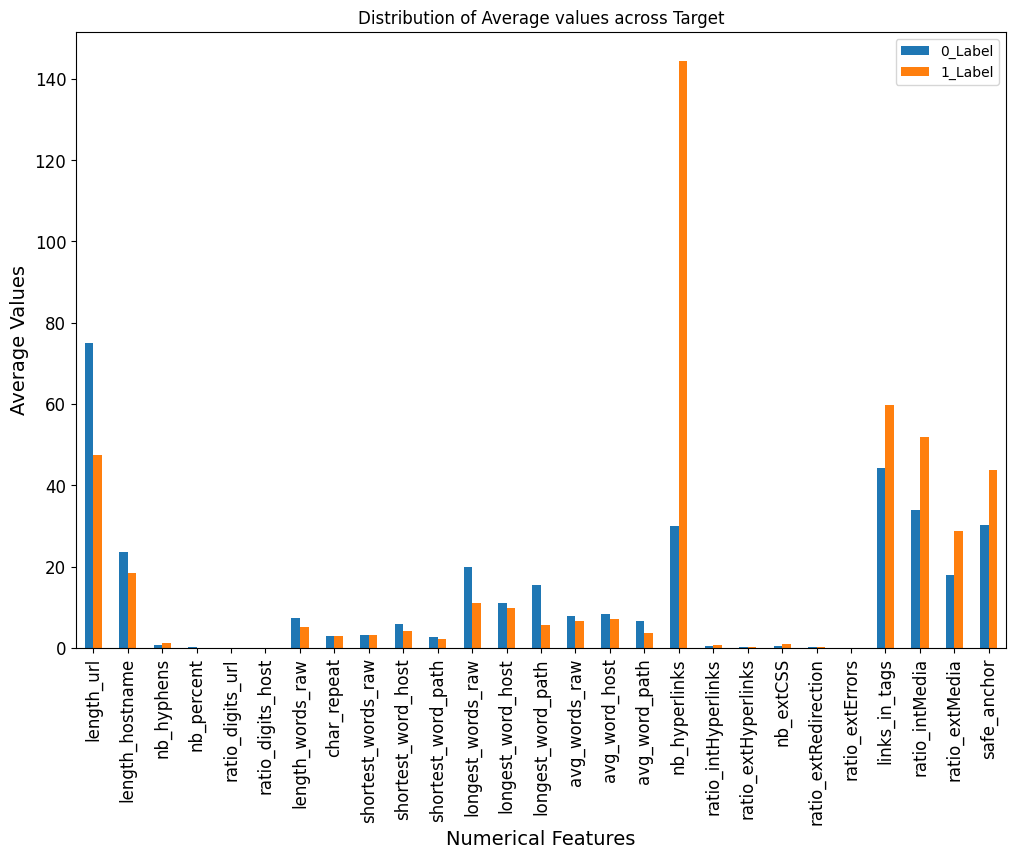

In [9]:
df_distr =df_data.groupby('target')[num_cols].mean().reset_index().T
df_distr.rename(columns={0:'0_Label',1:"1_Label"}, inplace=True)

#plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
ax = df_distr[1:-3][['0_Label','1_Label']].plot(kind='bar', title ="Distribution of Average values across Target", figsize=(12, 8), legend=True, fontsize=12)
ax.set_xlabel("Numerical Features", fontsize=14)
ax.set_ylabel("Average Values", fontsize=14)
#ax.set_ylim(0,500000)
plt.show()

**Observations**

* Higher the length of URL ,or words in URL then more likely to be *Phishing* URL
* Clear distinctive pattern of *nb_links* field.Higher implies *Legitimate* URL
* *links_in_tags ,safe_anchor*  higher volume signals more towards *Legitmate* site


**Exploring Page Ranks feature w.r.t Target variable**

* Legitimate URLs form more of a gaussian distribution as the ranking increases , whereas the Phishing ones present a right skewed distribution.Presence of differentiating patterns here

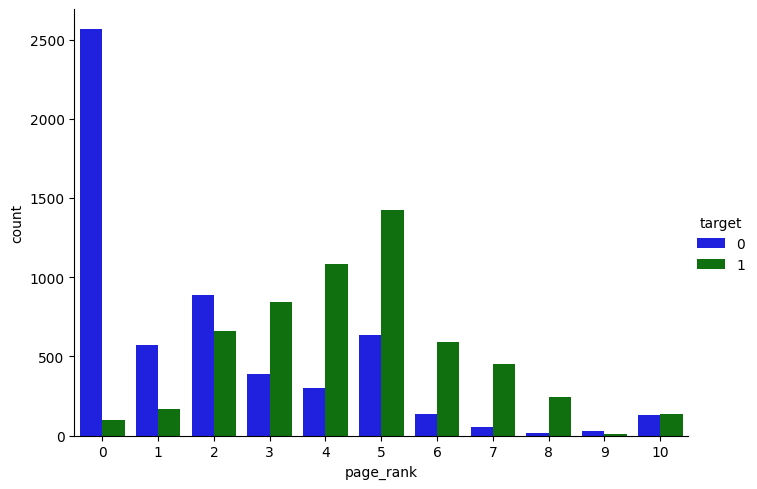

In [10]:
sns.catplot(x="page_rank", hue="target", data=df_data, kind="count", 
            palette={1:"green", 0:"blue"} ,height=5.0, aspect=11.7/8.27 )

**Note:**

* Aspects such has multicollinearity , variance captured by the features etc are applicable to Linear & Tree models as their performance tends to vary with these aspects.Since we are progressing with a Multi Layer Perceptron (MLP) , a neural net doesn't really care about all these transformations and raw data is what it needs to find the underlying patterns on it's own

#### Splitting dataset into Train & Test

In [32]:
#Train & Test Set
X= df_data.iloc[: , 1:-1]
#y = upsampled_df['Churn']
y= df_data['target']

train_x,test_x,train_y,test_y = train_test_split(X,y,random_state=42)
print("\n--Training data samples--")
print(train_x.shape)



--Training data samples--
(8572, 87)


# K-Folds Cross-Validation Concept:
This code implements K-Folds Cross-Validation, a technique used to evaluate the performance of a machine learning model more robustly. Instead of splitting the dataset once into training and testing sets, the data is split into 'k' subsets or 'folds'. The model is trained on 'k-1' folds and tested on the remaining fold. This process is repeated 'k' times, with each fold used as the test set once. The final result is the average performance across all folds, providing a more reliable estimate of the model's performance.

- **k = 2**: The number of folds is set to 2. This means the dataset will be split into 2 subsets, with 1 subset used for training and the other for testing, and then the roles are reversed for the second fold.
- **KFold(n_splits=k, shuffle=True, random_state=42)**: The `KFold` class from `sklearn.model_selection` is used to create the k-folds. 
    - `n_splits=k`: Specifies the number of folds.
    - `shuffle=True`: Shuffles the dataset before splitting into folds to ensure random distribution.
    - `random_state=42`: Fixes the random seed to make the results reproducible.
- **fold_no = 1**: Keeps track of the fold number in the cross-validation loop (used later when looping over folds).
- **all_fold_accuracies = []**: This list will store the accuracy scores from each fold to calculate the average accuracy across all folds at the end.

K-Folds Cross-Validation helps mitigate overfitting by evaluating the model on different subsets of the data and provides a more accurate estimate of model performance.

In [38]:
#CONCEPt KFOLDS
# Number of folds
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_no = 1
all_fold_accuracies = []

# K-Folds Cross-Validation Neural Network Training and Evaluation:

This block of code performs K-Folds Cross-Validation to train and evaluate an Artificial Neural Network (ANN) model on various folds of the data. This approach helps to assess the model's performance across different subsets of the dataset, providing more reliable and generalized results. Here's a step-by-step explanation:

1. **K-Folds Iteration**:
    - The code uses `kf.split(X)` to generate training and testing indices for each fold of the K-Folds Cross-Validation process.
    - For each fold, the training and testing data are split based on the current fold indices (`train_index` and `test_index`).

2. **Data Preprocessing**:
    - The data is split into training (`X_train`, `y_train`) and testing sets (`X_test`, `y_test`) for each fold.
    - A `MinMaxScaler` is used to scale the features to a range between 0 and 1. The scaler is fitted on the training data and applied to both the training and testing sets to ensure consistency.

3. **Converting Data to Tensors**:
    - The preprocessed training and testing data are converted to PyTorch tensors (`x_tensor`, `y_tensor`, `xtest_tensor`, `ytest_tensor`), which are required for training and evaluation in PyTorch.

4. **Model Definition**:
    - A neural network model is defined using PyTorch's `nn.Sequential`. The model consists of:
        - An input layer, followed by two hidden layers with 300 and 100 units, respectively.
        - Sigmoid activation functions are applied to both hidden layers.
        - Batch normalization is used after each hidden layer to improve training stability.
        - A Dropout layer is added to prevent overfitting by randomly turning off 10% of neurons.
        - The output layer consists of a single unit with a Sigmoid activation function, which is suitable for binary classification.

5. **Loss Function and Optimizer**:
    - The loss function used is `BCELoss` (Binary Cross-Entropy), appropriate for binary classification tasks.
    - The optimizer is Adam, a gradient-based optimization algorithm, with a learning rate of 0.001 to update the model's weights.

6. **Training Process**:
    - The model is trained for a fixed number of epochs (10) using mini-batches (batch size of 32).
    - For each epoch, the model performs forward propagation to predict outputs (`y_pred`) and computes the loss.
    - The gradients are backpropagated, and the optimizer updates the weights to minimize the loss.
    - During each epoch, the training loss and accuracy are tracked.

7. **Validation Step**:
    - After each epoch, the model is evaluated on the test data (`X_test`, `y_test`) by performing predictions.
    - The validation loss and accuracy are calculated and printed for each epoch, providing insights into how well the model generalizes to unseen data.

8. **Evaluation on Test Set**:
    - Once the model has been trained for all epochs, the final test set predictions are made and converted to binary outputs using a threshold of 0.5.
    - The accuracy of the model on the test set is computed using `accuracy_score`, and the result is stored for each fold.

9. **Confusion Matrix**:
    - A confusion matrix is generated and visualized using a heatmap to display how well the model performs in terms of True Positives, True Negatives, False Positives, and False Negatives.

10. **Fold Increment**:
    - After each fold, the `fold_no` is incremented, and the process repeats for the next fold.
    - Once all folds have been processed, the average accuracy across all folds is computed and printed as the final result.

### Output:
- **Training Fold**: The process prints the metrics for each fold, including training and validation loss/accuracy.
- **Confusion Matrix**: Visualized for each fold, providing insights into classification performance.
- **Average Accuracy**: After all folds are completed, the code calculates and prints the average accuracy across all folds, providing a reliable estimate of the model's performance.

Training fold 1...
Epoch 1/10 - loss: 0.2233 - accuracy: 0.9157 - val_loss: 0.1324 - val_accuracy: 0.9536
Epoch 2/10 - loss: 0.1900 - accuracy: 0.9287 - val_loss: 0.1212 - val_accuracy: 0.9589
Epoch 3/10 - loss: 0.1887 - accuracy: 0.9282 - val_loss: 0.1316 - val_accuracy: 0.9580
Epoch 4/10 - loss: 0.1788 - accuracy: 0.9319 - val_loss: 0.1167 - val_accuracy: 0.9598
Epoch 5/10 - loss: 0.1718 - accuracy: 0.9345 - val_loss: 0.1101 - val_accuracy: 0.9633
Epoch 6/10 - loss: 0.1621 - accuracy: 0.9368 - val_loss: 0.1074 - val_accuracy: 0.9668
Epoch 7/10 - loss: 0.1592 - accuracy: 0.9404 - val_loss: 0.1098 - val_accuracy: 0.9615
Epoch 8/10 - loss: 0.1450 - accuracy: 0.9468 - val_loss: 0.1073 - val_accuracy: 0.9624
Epoch 9/10 - loss: 0.1421 - accuracy: 0.9471 - val_loss: 0.0913 - val_accuracy: 0.9711
Epoch 10/10 - loss: 0.1354 - accuracy: 0.9497 - val_loss: 0.0987 - val_accuracy: 0.9685
Fold 1 Accuracy: 0.968503937007874


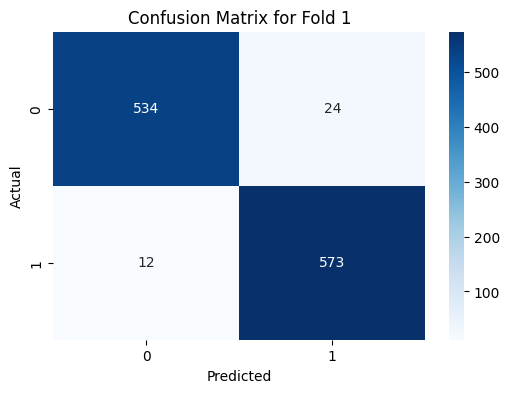

Training fold 2...
Epoch 1/10 - loss: 0.2133 - accuracy: 0.9173 - val_loss: 0.1632 - val_accuracy: 0.9309
Epoch 2/10 - loss: 0.1937 - accuracy: 0.9258 - val_loss: 0.1483 - val_accuracy: 0.9370
Epoch 3/10 - loss: 0.1805 - accuracy: 0.9293 - val_loss: 0.1352 - val_accuracy: 0.9458
Epoch 4/10 - loss: 0.1724 - accuracy: 0.9348 - val_loss: 0.1443 - val_accuracy: 0.9431
Epoch 5/10 - loss: 0.1703 - accuracy: 0.9357 - val_loss: 0.1398 - val_accuracy: 0.9440
Epoch 6/10 - loss: 0.1547 - accuracy: 0.9438 - val_loss: 0.1315 - val_accuracy: 0.9466
Epoch 7/10 - loss: 0.1509 - accuracy: 0.9460 - val_loss: 0.1296 - val_accuracy: 0.9528
Epoch 8/10 - loss: 0.1449 - accuracy: 0.9464 - val_loss: 0.1214 - val_accuracy: 0.9545
Epoch 9/10 - loss: 0.1345 - accuracy: 0.9514 - val_loss: 0.1286 - val_accuracy: 0.9554
Epoch 10/10 - loss: 0.1334 - accuracy: 0.9517 - val_loss: 0.1125 - val_accuracy: 0.9615
Fold 2 Accuracy: 0.9615048118985127


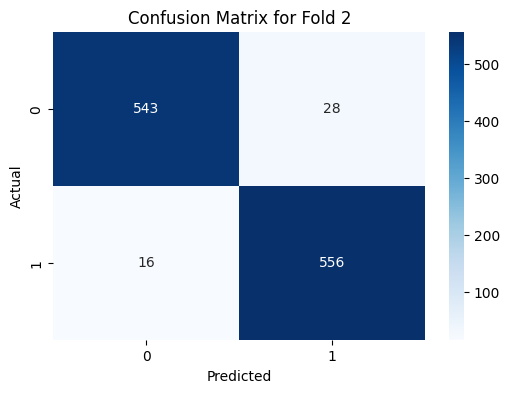

Training fold 3...
Epoch 1/10 - loss: 0.2153 - accuracy: 0.9182 - val_loss: 0.1837 - val_accuracy: 0.9353
Epoch 2/10 - loss: 0.1810 - accuracy: 0.9315 - val_loss: 0.1877 - val_accuracy: 0.9256
Epoch 3/10 - loss: 0.1734 - accuracy: 0.9333 - val_loss: 0.1611 - val_accuracy: 0.9370
Epoch 4/10 - loss: 0.1704 - accuracy: 0.9366 - val_loss: 0.1648 - val_accuracy: 0.9361
Epoch 5/10 - loss: 0.1617 - accuracy: 0.9410 - val_loss: 0.1465 - val_accuracy: 0.9458
Epoch 6/10 - loss: 0.1599 - accuracy: 0.9399 - val_loss: 0.1466 - val_accuracy: 0.9449
Epoch 7/10 - loss: 0.1537 - accuracy: 0.9437 - val_loss: 0.1341 - val_accuracy: 0.9475
Epoch 8/10 - loss: 0.1457 - accuracy: 0.9455 - val_loss: 0.1339 - val_accuracy: 0.9510
Epoch 9/10 - loss: 0.1351 - accuracy: 0.9498 - val_loss: 0.1285 - val_accuracy: 0.9545
Epoch 10/10 - loss: 0.1309 - accuracy: 0.9521 - val_loss: 0.1329 - val_accuracy: 0.9510
Fold 3 Accuracy: 0.9510061242344707


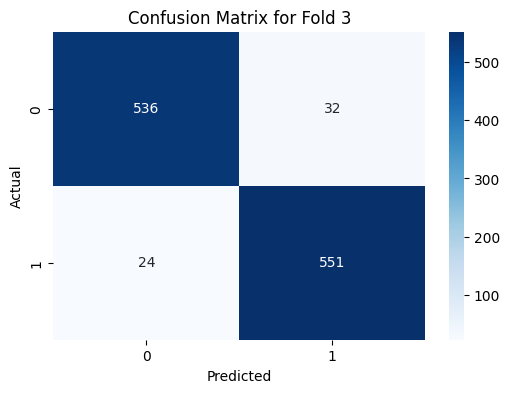

Training fold 4...
Epoch 1/10 - loss: 0.2198 - accuracy: 0.9160 - val_loss: 0.1887 - val_accuracy: 0.9248
Epoch 2/10 - loss: 0.1861 - accuracy: 0.9306 - val_loss: 0.1753 - val_accuracy: 0.9379
Epoch 3/10 - loss: 0.1817 - accuracy: 0.9324 - val_loss: 0.1631 - val_accuracy: 0.9405
Epoch 4/10 - loss: 0.1723 - accuracy: 0.9341 - val_loss: 0.1697 - val_accuracy: 0.9335
Epoch 5/10 - loss: 0.1597 - accuracy: 0.9398 - val_loss: 0.1662 - val_accuracy: 0.9344
Epoch 6/10 - loss: 0.1584 - accuracy: 0.9393 - val_loss: 0.1546 - val_accuracy: 0.9396
Epoch 7/10 - loss: 0.1504 - accuracy: 0.9425 - val_loss: 0.1548 - val_accuracy: 0.9449
Epoch 8/10 - loss: 0.1415 - accuracy: 0.9493 - val_loss: 0.1398 - val_accuracy: 0.9519
Epoch 9/10 - loss: 0.1378 - accuracy: 0.9483 - val_loss: 0.1416 - val_accuracy: 0.9466
Epoch 10/10 - loss: 0.1290 - accuracy: 0.9529 - val_loss: 0.1525 - val_accuracy: 0.9405
Fold 4 Accuracy: 0.9405074365704287


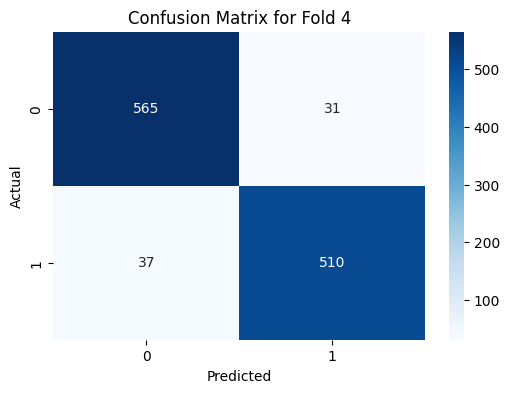

Training fold 5...
Epoch 1/10 - loss: 0.2096 - accuracy: 0.9196 - val_loss: 0.2139 - val_accuracy: 0.9134
Epoch 2/10 - loss: 0.1898 - accuracy: 0.9294 - val_loss: 0.2216 - val_accuracy: 0.9186
Epoch 3/10 - loss: 0.1782 - accuracy: 0.9332 - val_loss: 0.1845 - val_accuracy: 0.9309
Epoch 4/10 - loss: 0.1713 - accuracy: 0.9366 - val_loss: 0.1765 - val_accuracy: 0.9370
Epoch 5/10 - loss: 0.1664 - accuracy: 0.9378 - val_loss: 0.1766 - val_accuracy: 0.9300
Epoch 6/10 - loss: 0.1594 - accuracy: 0.9411 - val_loss: 0.1703 - val_accuracy: 0.9405
Epoch 7/10 - loss: 0.1492 - accuracy: 0.9431 - val_loss: 0.1555 - val_accuracy: 0.9440
Epoch 8/10 - loss: 0.1485 - accuracy: 0.9450 - val_loss: 0.1508 - val_accuracy: 0.9475
Epoch 9/10 - loss: 0.1433 - accuracy: 0.9478 - val_loss: 0.1507 - val_accuracy: 0.9431
Epoch 10/10 - loss: 0.1261 - accuracy: 0.9553 - val_loss: 0.1556 - val_accuracy: 0.9414
Fold 5 Accuracy: 0.9413823272090989


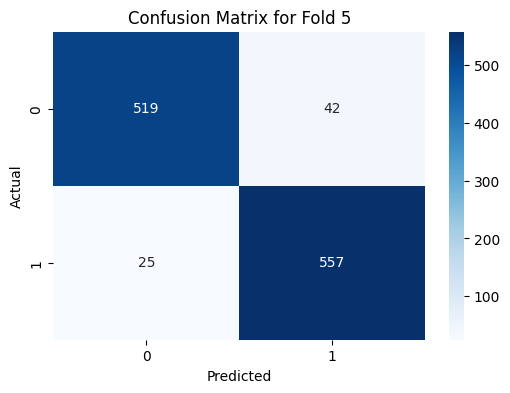

Training fold 6...
Epoch 1/10 - loss: 0.2125 - accuracy: 0.9172 - val_loss: 0.1750 - val_accuracy: 0.9396
Epoch 2/10 - loss: 0.1859 - accuracy: 0.9305 - val_loss: 0.1715 - val_accuracy: 0.9361
Epoch 3/10 - loss: 0.1772 - accuracy: 0.9344 - val_loss: 0.1709 - val_accuracy: 0.9361
Epoch 4/10 - loss: 0.1727 - accuracy: 0.9346 - val_loss: 0.1687 - val_accuracy: 0.9353
Epoch 5/10 - loss: 0.1642 - accuracy: 0.9381 - val_loss: 0.1527 - val_accuracy: 0.9466
Epoch 6/10 - loss: 0.1531 - accuracy: 0.9431 - val_loss: 0.1582 - val_accuracy: 0.9431
Epoch 7/10 - loss: 0.1514 - accuracy: 0.9440 - val_loss: 0.1605 - val_accuracy: 0.9431
Epoch 8/10 - loss: 0.1426 - accuracy: 0.9449 - val_loss: 0.1549 - val_accuracy: 0.9449
Epoch 9/10 - loss: 0.1346 - accuracy: 0.9495 - val_loss: 0.1577 - val_accuracy: 0.9466
Epoch 10/10 - loss: 0.1288 - accuracy: 0.9512 - val_loss: 0.1440 - val_accuracy: 0.9493
Fold 6 Accuracy: 0.9492563429571304


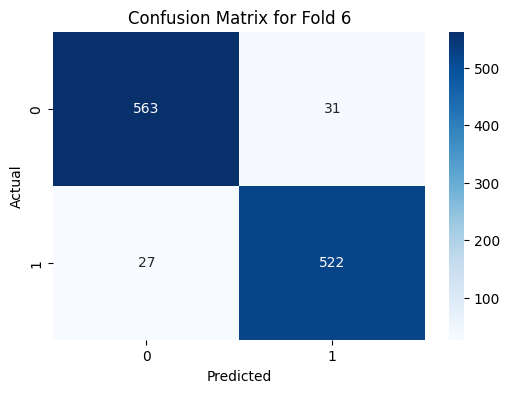

Training fold 7...
Epoch 1/10 - loss: 0.2159 - accuracy: 0.9159 - val_loss: 0.1739 - val_accuracy: 0.9344
Epoch 2/10 - loss: 0.1885 - accuracy: 0.9304 - val_loss: 0.1723 - val_accuracy: 0.9361
Epoch 3/10 - loss: 0.1832 - accuracy: 0.9298 - val_loss: 0.1502 - val_accuracy: 0.9431
Epoch 4/10 - loss: 0.1807 - accuracy: 0.9317 - val_loss: 0.1509 - val_accuracy: 0.9431
Epoch 5/10 - loss: 0.1671 - accuracy: 0.9390 - val_loss: 0.1378 - val_accuracy: 0.9571
Epoch 6/10 - loss: 0.1585 - accuracy: 0.9431 - val_loss: 0.1385 - val_accuracy: 0.9510
Epoch 7/10 - loss: 0.1506 - accuracy: 0.9457 - val_loss: 0.1345 - val_accuracy: 0.9501
Epoch 8/10 - loss: 0.1384 - accuracy: 0.9486 - val_loss: 0.1268 - val_accuracy: 0.9554
Epoch 9/10 - loss: 0.1332 - accuracy: 0.9511 - val_loss: 0.1268 - val_accuracy: 0.9589
Epoch 10/10 - loss: 0.1260 - accuracy: 0.9548 - val_loss: 0.1131 - val_accuracy: 0.9545
Fold 7 Accuracy: 0.9545056867891514


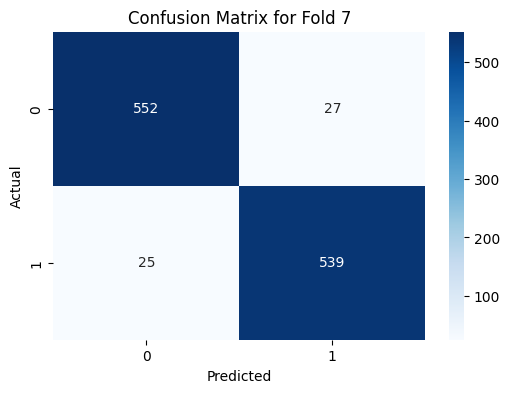

Training fold 8...
Epoch 1/10 - loss: 0.2215 - accuracy: 0.9155 - val_loss: 0.1764 - val_accuracy: 0.9344
Epoch 2/10 - loss: 0.1881 - accuracy: 0.9266 - val_loss: 0.1715 - val_accuracy: 0.9396
Epoch 3/10 - loss: 0.1833 - accuracy: 0.9321 - val_loss: 0.1511 - val_accuracy: 0.9431
Epoch 4/10 - loss: 0.1726 - accuracy: 0.9350 - val_loss: 0.1414 - val_accuracy: 0.9528
Epoch 5/10 - loss: 0.1586 - accuracy: 0.9425 - val_loss: 0.1422 - val_accuracy: 0.9510
Epoch 6/10 - loss: 0.1537 - accuracy: 0.9422 - val_loss: 0.1325 - val_accuracy: 0.9554
Epoch 7/10 - loss: 0.1476 - accuracy: 0.9460 - val_loss: 0.1351 - val_accuracy: 0.9545
Epoch 8/10 - loss: 0.1457 - accuracy: 0.9458 - val_loss: 0.1325 - val_accuracy: 0.9580
Epoch 9/10 - loss: 0.1366 - accuracy: 0.9496 - val_loss: 0.1253 - val_accuracy: 0.9519
Epoch 10/10 - loss: 0.1288 - accuracy: 0.9522 - val_loss: 0.1251 - val_accuracy: 0.9580
Fold 8 Accuracy: 0.958005249343832


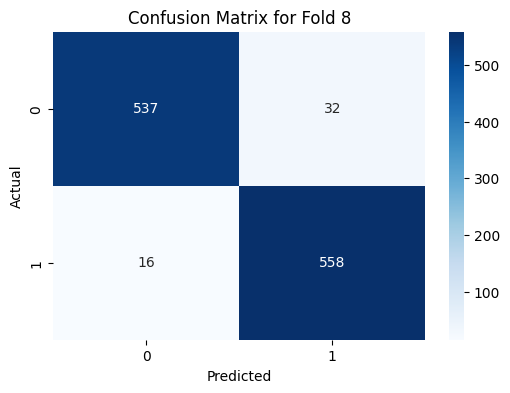

Training fold 9...
Epoch 1/10 - loss: 0.2192 - accuracy: 0.9157 - val_loss: 0.1749 - val_accuracy: 0.9353
Epoch 2/10 - loss: 0.1892 - accuracy: 0.9286 - val_loss: 0.1485 - val_accuracy: 0.9501
Epoch 3/10 - loss: 0.1807 - accuracy: 0.9301 - val_loss: 0.1493 - val_accuracy: 0.9475
Epoch 4/10 - loss: 0.1710 - accuracy: 0.9357 - val_loss: 0.1461 - val_accuracy: 0.9528
Epoch 5/10 - loss: 0.1679 - accuracy: 0.9397 - val_loss: 0.1376 - val_accuracy: 0.9528
Epoch 6/10 - loss: 0.1613 - accuracy: 0.9402 - val_loss: 0.1301 - val_accuracy: 0.9501
Epoch 7/10 - loss: 0.1456 - accuracy: 0.9457 - val_loss: 0.1252 - val_accuracy: 0.9528
Epoch 8/10 - loss: 0.1418 - accuracy: 0.9491 - val_loss: 0.1220 - val_accuracy: 0.9606
Epoch 9/10 - loss: 0.1405 - accuracy: 0.9484 - val_loss: 0.1406 - val_accuracy: 0.9545
Epoch 10/10 - loss: 0.1331 - accuracy: 0.9498 - val_loss: 0.1253 - val_accuracy: 0.9554
Fold 9 Accuracy: 0.9553805774278216


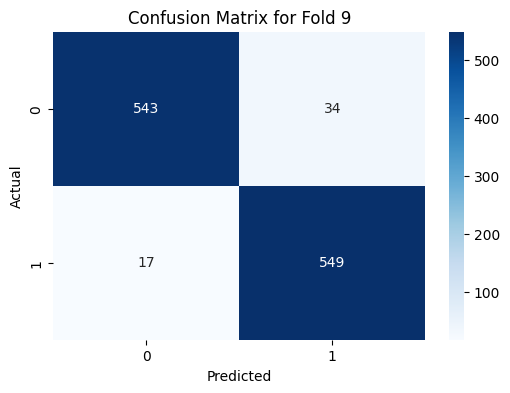

Training fold 10...
Epoch 1/10 - loss: 0.2196 - accuracy: 0.9162 - val_loss: 0.1710 - val_accuracy: 0.9388
Epoch 2/10 - loss: 0.1928 - accuracy: 0.9254 - val_loss: 0.1608 - val_accuracy: 0.9431
Epoch 3/10 - loss: 0.1763 - accuracy: 0.9336 - val_loss: 0.1525 - val_accuracy: 0.9431
Epoch 4/10 - loss: 0.1705 - accuracy: 0.9368 - val_loss: 0.1461 - val_accuracy: 0.9493
Epoch 5/10 - loss: 0.1663 - accuracy: 0.9363 - val_loss: 0.1330 - val_accuracy: 0.9536
Epoch 6/10 - loss: 0.1567 - accuracy: 0.9418 - val_loss: 0.1371 - val_accuracy: 0.9528
Epoch 7/10 - loss: 0.1445 - accuracy: 0.9467 - val_loss: 0.1395 - val_accuracy: 0.9501
Epoch 8/10 - loss: 0.1395 - accuracy: 0.9486 - val_loss: 0.1350 - val_accuracy: 0.9563
Epoch 9/10 - loss: 0.1341 - accuracy: 0.9521 - val_loss: 0.1314 - val_accuracy: 0.9571
Epoch 10/10 - loss: 0.1314 - accuracy: 0.9524 - val_loss: 0.1292 - val_accuracy: 0.9536
Fold 10 Accuracy: 0.9536307961504812


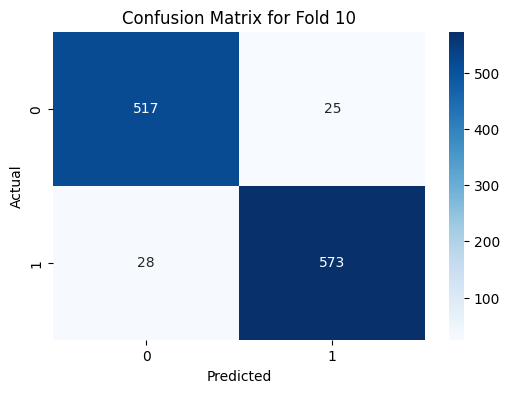

Average Accuracy after 10 folds: 0.9533683289588801


In [39]:
for train_index, test_index in kf.split(X):
    print(f"Training fold {fold_no}...")

    # Split the dataset into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the features using MinMaxScaler
    scaler = preprocessing.MinMaxScaler()
    X_train = scaler.fit_transform(X_train.values)
    X_test = scaler.transform(X_test.values)

    # Convert data to PyTorch tensors
    x_tensor = torch.from_numpy(X_train).float()
    y_tensor = torch.from_numpy(y_train.values.ravel()).float()
    xtest_tensor = torch.from_numpy(X_test).float()
    ytest_tensor = torch.from_numpy(y_test.values.ravel()).float()

    # Define the model with Sigmoid activation in hidden layers
    model = nn.Sequential(
        nn.Linear(X_train.shape[1], 300),
        nn.Sigmoid(),
        nn.BatchNorm1d(300),
        nn.Linear(300, 100),
        nn.Sigmoid(),
        nn.BatchNorm1d(100),
        nn.Dropout(0.1),
        nn.Linear(100, 1),
        nn.Sigmoid()
    )

    # Define loss function and optimizer
    loss_func = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training the model
    model.train()
    epochs = 10
    batch_size = 32
    train_data = torch.utils.data.TensorDataset(x_tensor, y_tensor)
    train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0  # To track the loss during each epoch
        correct_train = 0  # To count correct predictions during training
        total_train = 0     # To count total training examples

        for xb, yb in train_dl:
            y_pred = model(xb)  # Forward Propagation
            loss = loss_func(y_pred, yb.view(-1, 1))  # Compute Loss
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights

            running_loss += loss.item()  # Add the loss for this batch

            # Calculate accuracy during training
            predicted = (y_pred > 0.5).float()
            correct_train += (predicted == yb.view(-1, 1)).sum().item()
            total_train += yb.size(0)

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_dl)
        train_accuracy = correct_train / total_train

        # Validation step
        model.eval()
        with torch.no_grad():
            y_val_pred = model(xtest_tensor)
            val_loss = loss_func(y_val_pred, ytest_tensor.view(-1, 1)).item()
            val_predicted = (y_val_pred > 0.5).float()
            val_accuracy = (val_predicted == ytest_tensor.view(-1, 1)).float().mean().item()

        # Print the epoch metrics
        print(f"Epoch {epoch + 1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(xtest_tensor)
        y_pred = (y_pred_prob > 0.5).float()  # Convert to binary predictions

    # Calculate accuracy
    accuracy = accuracy_score(ytest_tensor, y_pred)
    print(f"Fold {fold_no} Accuracy: {accuracy}")
    all_fold_accuracies.append(accuracy)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(ytest_tensor, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.show()

    # Increment fold number
    fold_no += 1

# Average accuracy across all folds
average_accuracy = np.mean(all_fold_accuracies)
print(f"Average Accuracy after {kf.get_n_splits()} folds: {average_accuracy}")

# This variation of the model tests how using the ReLU (Rectified Linear Unit) activation function in the hidden layers compares to using Sigmoid activation (as in the previous version). Specifically, it evaluates:

Convergence Speed: ReLU tends to converge faster than Sigmoid by mitigating issues like vanishing gradients during training. This variation tests whether the model can train more efficiently using ReLU.
Model Performance: By allowing more complex learning through ReLU, which is better suited for deeper networks, this variation assesses if the model achieves better accuracy and lower loss during both training and validation.
Generalization: The variation helps explore whether ReLU can improve generalization, potentially leading to higher average accuracy across folds compared to Sigmoid.
In summary, this variation primarily tests if the switch to ReLU improves the neural network's training dynamics and overall classification performance.

Training fold 1...
Epoch 1/10 - loss: 0.2016 - accuracy: 0.9220 - val_loss: 0.1241 - val_accuracy: 0.9563
Epoch 2/10 - loss: 0.1561 - accuracy: 0.9431 - val_loss: 0.1049 - val_accuracy: 0.9641
Epoch 3/10 - loss: 0.1322 - accuracy: 0.9516 - val_loss: 0.0950 - val_accuracy: 0.9668
Epoch 4/10 - loss: 0.1221 - accuracy: 0.9563 - val_loss: 0.0899 - val_accuracy: 0.9694
Epoch 5/10 - loss: 0.1102 - accuracy: 0.9593 - val_loss: 0.0976 - val_accuracy: 0.9650
Epoch 6/10 - loss: 0.1067 - accuracy: 0.9625 - val_loss: 0.0933 - val_accuracy: 0.9703
Epoch 7/10 - loss: 0.1004 - accuracy: 0.9639 - val_loss: 0.0989 - val_accuracy: 0.9694
Epoch 8/10 - loss: 0.0978 - accuracy: 0.9659 - val_loss: 0.0956 - val_accuracy: 0.9703
Epoch 9/10 - loss: 0.0856 - accuracy: 0.9680 - val_loss: 0.0981 - val_accuracy: 0.9668
Epoch 10/10 - loss: 0.0854 - accuracy: 0.9689 - val_loss: 0.1018 - val_accuracy: 0.9641
Fold 1 Accuracy: 0.9641294838145232


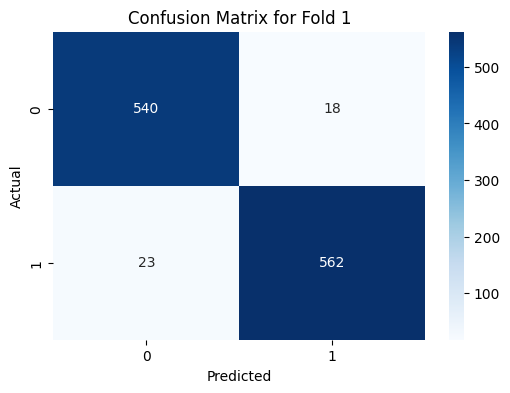

Training fold 2...
Epoch 1/10 - loss: 0.2000 - accuracy: 0.9243 - val_loss: 0.1205 - val_accuracy: 0.9501
Epoch 2/10 - loss: 0.1483 - accuracy: 0.9476 - val_loss: 0.1281 - val_accuracy: 0.9493
Epoch 3/10 - loss: 0.1276 - accuracy: 0.9557 - val_loss: 0.1285 - val_accuracy: 0.9466
Epoch 4/10 - loss: 0.1164 - accuracy: 0.9572 - val_loss: 0.1290 - val_accuracy: 0.9449
Epoch 5/10 - loss: 0.1106 - accuracy: 0.9605 - val_loss: 0.1185 - val_accuracy: 0.9528
Epoch 6/10 - loss: 0.0969 - accuracy: 0.9648 - val_loss: 0.1211 - val_accuracy: 0.9545
Epoch 7/10 - loss: 0.0965 - accuracy: 0.9654 - val_loss: 0.1347 - val_accuracy: 0.9475
Epoch 8/10 - loss: 0.0919 - accuracy: 0.9655 - val_loss: 0.1347 - val_accuracy: 0.9554
Epoch 9/10 - loss: 0.0805 - accuracy: 0.9719 - val_loss: 0.1343 - val_accuracy: 0.9580
Epoch 10/10 - loss: 0.0823 - accuracy: 0.9696 - val_loss: 0.1277 - val_accuracy: 0.9536
Fold 2 Accuracy: 0.9536307961504812


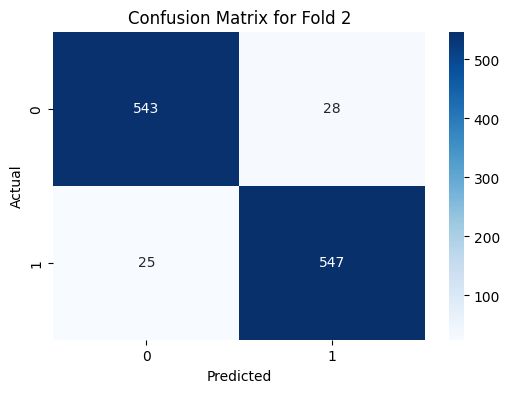

Training fold 3...
Epoch 1/10 - loss: 0.1905 - accuracy: 0.9264 - val_loss: 0.1568 - val_accuracy: 0.9475
Epoch 2/10 - loss: 0.1481 - accuracy: 0.9473 - val_loss: 0.1498 - val_accuracy: 0.9423
Epoch 3/10 - loss: 0.1326 - accuracy: 0.9513 - val_loss: 0.1379 - val_accuracy: 0.9510
Epoch 4/10 - loss: 0.1202 - accuracy: 0.9559 - val_loss: 0.1450 - val_accuracy: 0.9536
Epoch 5/10 - loss: 0.1117 - accuracy: 0.9600 - val_loss: 0.1468 - val_accuracy: 0.9466
Epoch 6/10 - loss: 0.1018 - accuracy: 0.9632 - val_loss: 0.1561 - val_accuracy: 0.9563
Epoch 7/10 - loss: 0.0962 - accuracy: 0.9649 - val_loss: 0.1515 - val_accuracy: 0.9528
Epoch 8/10 - loss: 0.0890 - accuracy: 0.9683 - val_loss: 0.1171 - val_accuracy: 0.9615
Epoch 9/10 - loss: 0.0850 - accuracy: 0.9678 - val_loss: 0.1480 - val_accuracy: 0.9536
Epoch 10/10 - loss: 0.0854 - accuracy: 0.9690 - val_loss: 0.1476 - val_accuracy: 0.9545
Fold 3 Accuracy: 0.9545056867891514


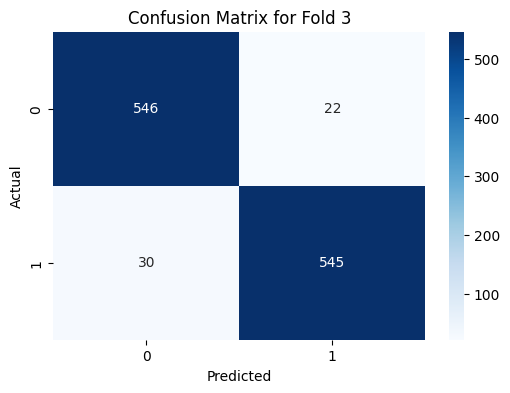

Training fold 4...
Epoch 1/10 - loss: 0.1896 - accuracy: 0.9310 - val_loss: 0.1390 - val_accuracy: 0.9528
Epoch 2/10 - loss: 0.1431 - accuracy: 0.9489 - val_loss: 0.1405 - val_accuracy: 0.9493
Epoch 3/10 - loss: 0.1269 - accuracy: 0.9535 - val_loss: 0.1318 - val_accuracy: 0.9545
Epoch 4/10 - loss: 0.1175 - accuracy: 0.9575 - val_loss: 0.1293 - val_accuracy: 0.9528
Epoch 5/10 - loss: 0.1079 - accuracy: 0.9595 - val_loss: 0.1281 - val_accuracy: 0.9501
Epoch 6/10 - loss: 0.1034 - accuracy: 0.9630 - val_loss: 0.1244 - val_accuracy: 0.9589
Epoch 7/10 - loss: 0.0964 - accuracy: 0.9640 - val_loss: 0.1380 - val_accuracy: 0.9571
Epoch 8/10 - loss: 0.0899 - accuracy: 0.9654 - val_loss: 0.1446 - val_accuracy: 0.9466
Epoch 9/10 - loss: 0.0914 - accuracy: 0.9669 - val_loss: 0.1522 - val_accuracy: 0.9510
Epoch 10/10 - loss: 0.0838 - accuracy: 0.9708 - val_loss: 0.1579 - val_accuracy: 0.9536
Fold 4 Accuracy: 0.9536307961504812


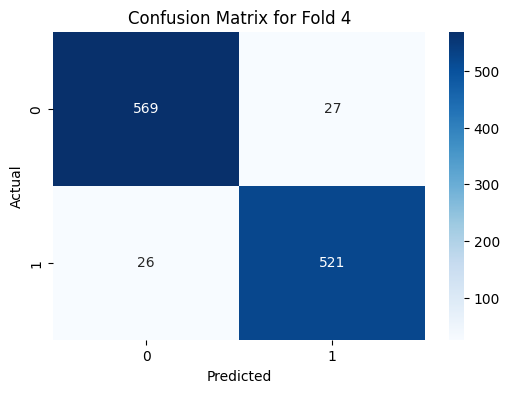

Training fold 5...
Epoch 1/10 - loss: 0.1938 - accuracy: 0.9286 - val_loss: 0.1683 - val_accuracy: 0.9388
Epoch 2/10 - loss: 0.1404 - accuracy: 0.9468 - val_loss: 0.1720 - val_accuracy: 0.9396
Epoch 3/10 - loss: 0.1222 - accuracy: 0.9542 - val_loss: 0.1662 - val_accuracy: 0.9466
Epoch 4/10 - loss: 0.1117 - accuracy: 0.9597 - val_loss: 0.1489 - val_accuracy: 0.9493
Epoch 5/10 - loss: 0.1074 - accuracy: 0.9599 - val_loss: 0.1684 - val_accuracy: 0.9519
Epoch 6/10 - loss: 0.1047 - accuracy: 0.9605 - val_loss: 0.1552 - val_accuracy: 0.9449
Epoch 7/10 - loss: 0.0923 - accuracy: 0.9665 - val_loss: 0.2550 - val_accuracy: 0.9510
Epoch 8/10 - loss: 0.0825 - accuracy: 0.9686 - val_loss: 0.2366 - val_accuracy: 0.9484
Epoch 9/10 - loss: 0.0832 - accuracy: 0.9680 - val_loss: 0.2486 - val_accuracy: 0.9493
Epoch 10/10 - loss: 0.0820 - accuracy: 0.9710 - val_loss: 0.2539 - val_accuracy: 0.9431
Fold 5 Accuracy: 0.9431321084864392


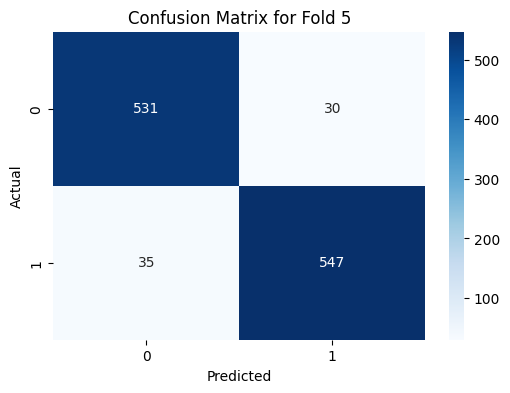

Training fold 6...
Epoch 1/10 - loss: 0.1903 - accuracy: 0.9271 - val_loss: 0.1688 - val_accuracy: 0.9405
Epoch 2/10 - loss: 0.1446 - accuracy: 0.9489 - val_loss: 0.1449 - val_accuracy: 0.9519
Epoch 3/10 - loss: 0.1272 - accuracy: 0.9541 - val_loss: 0.1572 - val_accuracy: 0.9545
Epoch 4/10 - loss: 0.1187 - accuracy: 0.9569 - val_loss: 0.1533 - val_accuracy: 0.9589
Epoch 5/10 - loss: 0.1062 - accuracy: 0.9618 - val_loss: 0.1509 - val_accuracy: 0.9571
Epoch 6/10 - loss: 0.1031 - accuracy: 0.9629 - val_loss: 0.1521 - val_accuracy: 0.9545
Epoch 7/10 - loss: 0.0907 - accuracy: 0.9692 - val_loss: 0.1523 - val_accuracy: 0.9528
Epoch 8/10 - loss: 0.0884 - accuracy: 0.9671 - val_loss: 0.2400 - val_accuracy: 0.9493
Epoch 9/10 - loss: 0.0837 - accuracy: 0.9708 - val_loss: 0.1589 - val_accuracy: 0.9554
Epoch 10/10 - loss: 0.0808 - accuracy: 0.9706 - val_loss: 0.1786 - val_accuracy: 0.9484
Fold 6 Accuracy: 0.9483814523184602


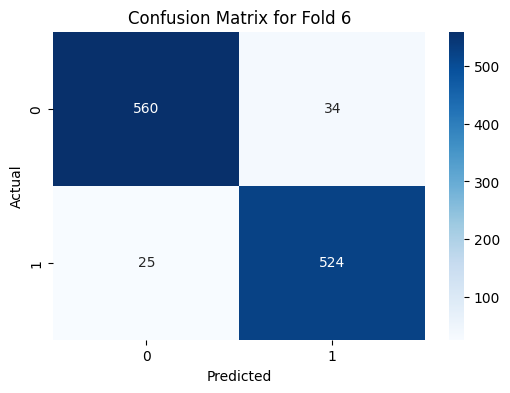

Training fold 7...
Epoch 1/10 - loss: 0.2030 - accuracy: 0.9229 - val_loss: 0.1625 - val_accuracy: 0.9440
Epoch 2/10 - loss: 0.1472 - accuracy: 0.9459 - val_loss: 0.1223 - val_accuracy: 0.9571
Epoch 3/10 - loss: 0.1363 - accuracy: 0.9499 - val_loss: 0.1195 - val_accuracy: 0.9545
Epoch 4/10 - loss: 0.1243 - accuracy: 0.9551 - val_loss: 0.1164 - val_accuracy: 0.9589
Epoch 5/10 - loss: 0.1116 - accuracy: 0.9602 - val_loss: 0.1303 - val_accuracy: 0.9563
Epoch 6/10 - loss: 0.1045 - accuracy: 0.9620 - val_loss: 0.1159 - val_accuracy: 0.9606
Epoch 7/10 - loss: 0.0938 - accuracy: 0.9661 - val_loss: 0.1198 - val_accuracy: 0.9580
Epoch 8/10 - loss: 0.0933 - accuracy: 0.9672 - val_loss: 0.1291 - val_accuracy: 0.9545
Epoch 9/10 - loss: 0.0876 - accuracy: 0.9692 - val_loss: 0.1301 - val_accuracy: 0.9633
Epoch 10/10 - loss: 0.0817 - accuracy: 0.9710 - val_loss: 0.1225 - val_accuracy: 0.9563
Fold 7 Accuracy: 0.9562554680664916


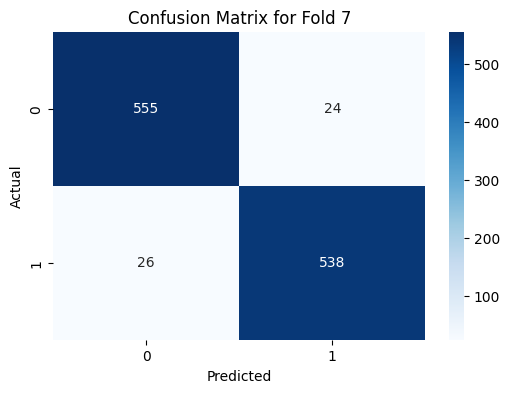

Training fold 8...
Epoch 1/10 - loss: 0.1989 - accuracy: 0.9247 - val_loss: 0.1401 - val_accuracy: 0.9536
Epoch 2/10 - loss: 0.1450 - accuracy: 0.9453 - val_loss: 0.1501 - val_accuracy: 0.9388
Epoch 3/10 - loss: 0.1266 - accuracy: 0.9529 - val_loss: 0.1390 - val_accuracy: 0.9493
Epoch 4/10 - loss: 0.1199 - accuracy: 0.9538 - val_loss: 0.1320 - val_accuracy: 0.9519
Epoch 5/10 - loss: 0.1113 - accuracy: 0.9600 - val_loss: 0.1470 - val_accuracy: 0.9536
Epoch 6/10 - loss: 0.1022 - accuracy: 0.9627 - val_loss: 0.1174 - val_accuracy: 0.9598
Epoch 7/10 - loss: 0.0989 - accuracy: 0.9639 - val_loss: 0.1213 - val_accuracy: 0.9519
Epoch 8/10 - loss: 0.0941 - accuracy: 0.9653 - val_loss: 0.1494 - val_accuracy: 0.9493
Epoch 9/10 - loss: 0.0858 - accuracy: 0.9686 - val_loss: 0.1195 - val_accuracy: 0.9589
Epoch 10/10 - loss: 0.0797 - accuracy: 0.9719 - val_loss: 0.1404 - val_accuracy: 0.9528
Fold 8 Accuracy: 0.952755905511811


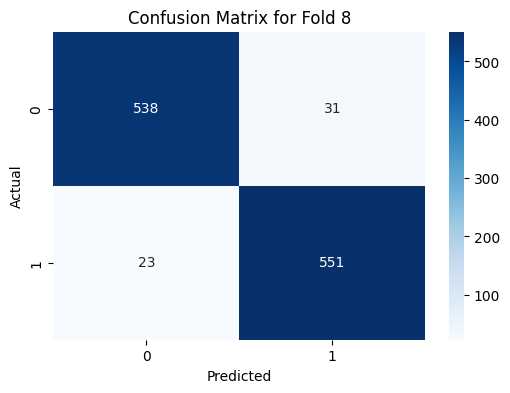

Training fold 9...
Epoch 1/10 - loss: 0.1926 - accuracy: 0.9278 - val_loss: 0.1358 - val_accuracy: 0.9484
Epoch 2/10 - loss: 0.1426 - accuracy: 0.9497 - val_loss: 0.1251 - val_accuracy: 0.9598
Epoch 3/10 - loss: 0.1295 - accuracy: 0.9517 - val_loss: 0.1182 - val_accuracy: 0.9571
Epoch 4/10 - loss: 0.1181 - accuracy: 0.9573 - val_loss: 0.1382 - val_accuracy: 0.9545
Epoch 5/10 - loss: 0.1106 - accuracy: 0.9603 - val_loss: 0.1239 - val_accuracy: 0.9589
Epoch 6/10 - loss: 0.1072 - accuracy: 0.9614 - val_loss: 0.1283 - val_accuracy: 0.9624
Epoch 7/10 - loss: 0.0947 - accuracy: 0.9662 - val_loss: 0.1149 - val_accuracy: 0.9624
Epoch 8/10 - loss: 0.0907 - accuracy: 0.9676 - val_loss: 0.1038 - val_accuracy: 0.9668
Epoch 9/10 - loss: 0.0853 - accuracy: 0.9688 - val_loss: 0.1217 - val_accuracy: 0.9650
Epoch 10/10 - loss: 0.0756 - accuracy: 0.9727 - val_loss: 0.1388 - val_accuracy: 0.9554
Fold 9 Accuracy: 0.9553805774278216


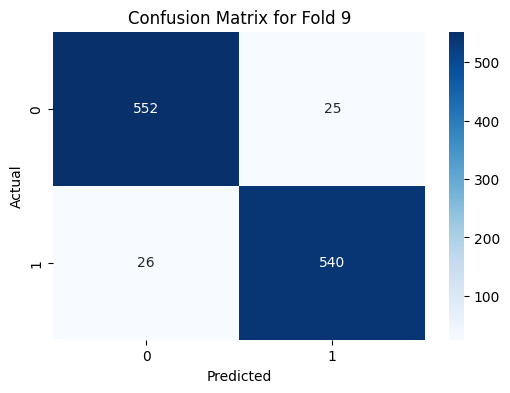

Training fold 10...
Epoch 1/10 - loss: 0.1990 - accuracy: 0.9223 - val_loss: 0.1458 - val_accuracy: 0.9423
Epoch 2/10 - loss: 0.1417 - accuracy: 0.9476 - val_loss: 0.1419 - val_accuracy: 0.9449
Epoch 3/10 - loss: 0.1384 - accuracy: 0.9480 - val_loss: 0.1318 - val_accuracy: 0.9528
Epoch 4/10 - loss: 0.1162 - accuracy: 0.9584 - val_loss: 0.1272 - val_accuracy: 0.9545
Epoch 5/10 - loss: 0.1117 - accuracy: 0.9621 - val_loss: 0.1327 - val_accuracy: 0.9528
Epoch 6/10 - loss: 0.1026 - accuracy: 0.9638 - val_loss: 0.1170 - val_accuracy: 0.9571
Epoch 7/10 - loss: 0.0954 - accuracy: 0.9658 - val_loss: 0.1355 - val_accuracy: 0.9545
Epoch 8/10 - loss: 0.0911 - accuracy: 0.9677 - val_loss: 0.1222 - val_accuracy: 0.9571
Epoch 9/10 - loss: 0.0861 - accuracy: 0.9695 - val_loss: 0.1223 - val_accuracy: 0.9580
Epoch 10/10 - loss: 0.0833 - accuracy: 0.9691 - val_loss: 0.1371 - val_accuracy: 0.9563
Fold 10 Accuracy: 0.9562554680664916


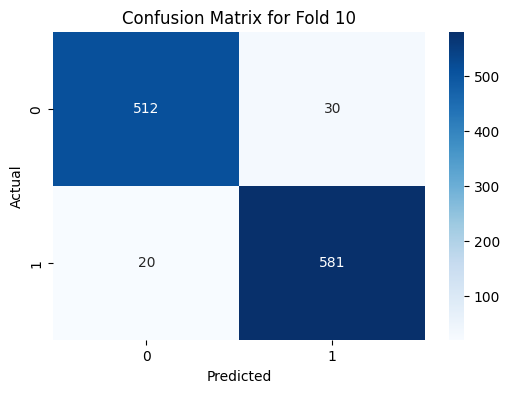

Average Accuracy after 10 folds: 0.9535870516185476


In [40]:
fold_no = 1
for train_index, test_index in kf.split(X):
        
    print(f"Training fold {fold_no}...")

    # Split the dataset into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the features using MinMaxScaler
    scaler = preprocessing.MinMaxScaler()
    X_train = scaler.fit_transform(X_train.values)
    X_test = scaler.transform(X_test.values)

    # Convert data to PyTorch tensors
    x_tensor = torch.from_numpy(X_train).float()
    y_tensor = torch.from_numpy(y_train.values.ravel()).float()
    xtest_tensor = torch.from_numpy(X_test).float()
    ytest_tensor = torch.from_numpy(y_test.values.ravel()).float()

   # Define the model with ReLU activation in hidden layers
    model = nn.Sequential(
    nn.Linear(X_train.shape[1], 300),
    nn.ReLU(),  # Changed from Sigmoid to ReLU
    nn.BatchNorm1d(300),
    nn.Linear(300, 100),
    nn.ReLU(),  # Changed from Sigmoid to ReLU
    nn.BatchNorm1d(100),
    nn.Dropout(0.1),
    nn.Linear(100, 1),
    nn.Sigmoid()  # Keep Sigmoid in the output layer for binary classification
    )

    # Define loss function and optimizer
    loss_func = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training the model
    model.train()
    epochs = 10
    batch_size = 32
    train_data = torch.utils.data.TensorDataset(x_tensor, y_tensor)
    train_dl = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0  # To track the loss during each epoch
        correct_train = 0  # To count correct predictions during training
        total_train = 0     # To count total training examples

        for xb, yb in train_dl:
            y_pred = model(xb)  # Forward Propagation
            loss = loss_func(y_pred, yb.view(-1, 1))  # Compute Loss
            optimizer.zero_grad()  # Zero the gradients
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights

            running_loss += loss.item()  # Add the loss for this batch

            # Calculate accuracy during training
            predicted = (y_pred > 0.5).float()
            correct_train += (predicted == yb.view(-1, 1)).sum().item()
            total_train += yb.size(0)

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_dl)
        train_accuracy = correct_train / total_train

        # Validation step
        model.eval()
        with torch.no_grad():
            y_val_pred = model(xtest_tensor)
            val_loss = loss_func(y_val_pred, ytest_tensor.view(-1, 1)).item()
            val_predicted = (y_val_pred > 0.5).float()
            val_accuracy = (val_predicted == ytest_tensor.view(-1, 1)).float().mean().item()

        # Print the epoch metrics
        print(f"Epoch {epoch + 1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

    # Evaluate the model on the test set
    model.eval()
    with torch.no_grad():
        y_pred_prob = model(xtest_tensor)
        y_pred = (y_pred_prob > 0.5).float()  # Convert to binary predictions

    # Calculate accuracy
    accuracy = accuracy_score(ytest_tensor, y_pred)
    print(f"Fold {fold_no} Accuracy: {accuracy}")
    all_fold_accuracies.append(accuracy)

    # Generate confusion matrix
    conf_matrix = confusion_matrix(ytest_tensor, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.show()

    # Increment fold number
    fold_no += 1

# Average accuracy across all folds
average_accuracy = np.mean(all_fold_accuracies)
print(f"Average Accuracy after {kf.get_n_splits()} folds: {average_accuracy}")